# Coding Exercise 1: Simulating SDEs
In this exercise, we will learn how to numerically simulate SDEs, and in particular the Langevin diffusion.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.func import vmap, jacrev
from abc import ABC, abstractmethod
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# set random seeds for reproducibility
np.random.seed(12345)
torch.manual_seed(12345)

## Section 1: specify a distribution
To distinguish all kinds of distributions, we specify
- whether it has an explicit density
- whether we can sample from it

This is a bit cumbersome in practice, but helps us to organize the code and teach concepts

In [3]:
class Density(ABC):
    @abstractmethod
    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x
        """
        pass
    
    def score(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the score function at x, i.e. the gradient of the log density
        The advantage of torch is that we can compute the score function using automatic differentiation, without having to derive it analytically
        """
        x = x.unsqueeze(1)  # (batch_size, 1, ...)
        score = vmap(jacrev(self.log_prob))(x)  # (batch_size, 1, 1, 1, ...)
        return score.squeeze((1, 2, 3))  # (batch_size, ...)
    

class Sampleable(ABC):
    @abstractmethod
    def sample(self, num_samples: int):
        """
        Return num_samples samples from the distribution
        """
        pass

In [4]:
# examples of distributions
class Gaussian(torch.nn.Module, Density, Sampleable):
    """
    Gaussian with mean and covariance
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        super().__init__()
        self.mean = mean
        self.cov = cov
        self.inv_cov = torch.linalg.inv(cov)
        self.log_det_cov = torch.logdet(cov)
        self.dim = mean.shape[0]

    def log_prob(self, x):
        return torch.distributions.MultivariateNormal(self.mean, self.cov, validate_args=False).log_prob(x).view(-1, 1)

    def sample(self, num_samples: int):
        # use built-in multivariate normal distribution to sample
        return torch.distributions.MultivariateNormal(self.mean, self.cov).sample((num_samples,))

class MixtureOfGaussians(torch.nn.Module, Density, Sampleable):
    """
    Mixture of Gaussians with given means, covariances, and weights
    """
    def __init__(self, means: torch.Tensor, covs: torch.Tensor, weights: torch.Tensor):
        super().__init__()
        self.means = means
        self.covs = covs
        self.weights = weights / weights.sum()  # normalize weights
        self.num_components = means.shape[0]
        self.dim = means.shape[1]
        self.components = [Gaussian(means[i], covs[i]) for i in range(self.num_components)]

    def log_prob(self, x):
        log_probs = torch.stack([comp.log_prob(x) + torch.log(weight) for comp, weight in zip(self.components, self.weights)], dim=0)
        return torch.logsumexp(log_probs, dim=0)

    def sample(self, num_samples: int):
        samples = []
        for _ in range(num_samples):
            component = np.random.choice(self.num_components, p=self.weights.cpu().numpy())
            samples.append(self.components[component].sample(1))
        return torch.cat(samples, dim=0)
    
    @classmethod
    def random_2D(
        cls, num_components: int, mean_range: float = 10.0, cov_range: float = 5.0
    ) -> "MixtureOfGaussians":
        means = torch.rand(num_components, 2) * mean_range - mean_range / 2
        covs = torch.stack([torch.diag(torch.rand(2) * cov_range + 0.5) for _ in range(num_components)], dim=0)
        weights = torch.rand(num_components)
        return cls(means, covs, weights)
    
    @classmethod
    def circle_2D(
        cls, num_components: int, radius: float = 5.0, cov_range: float = 1.0
    ) -> "MixtureOfGaussians":
        """
        Create a mixture of Gaussians arranged in a circle. The means are placed evenly around the circle with the given radius, and the covariances are random diagonal matrices with values in the given range.
        """
        angles = torch.linspace(0, 2 * np.pi, num_components+1)[:-1] # exclude the last point which is the same as the first
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * radius
        covs = torch.stack([torch.diag(torch.rand(2) * cov_range + 0.5) for _ in range(num_components)], dim=0)
        weights = torch.rand(num_components)
        return cls(means, covs, weights)

In [5]:
# Visualize densities
densities = {
    "Gaussian": Gaussian(mean=torch.zeros(2), cov=10 * torch.eye(2)).to(device),
    "Random Mixture": MixtureOfGaussians.random_2D(num_components=5, mean_range=5.0, cov_range=2.0).to(device),
    "Symmetric Mixture": MixtureOfGaussians.circle_2D(num_components=5, radius=5.0, cov_range=2.0).to(device),
}


/opt/miniconda3/envs/py312/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403213615/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


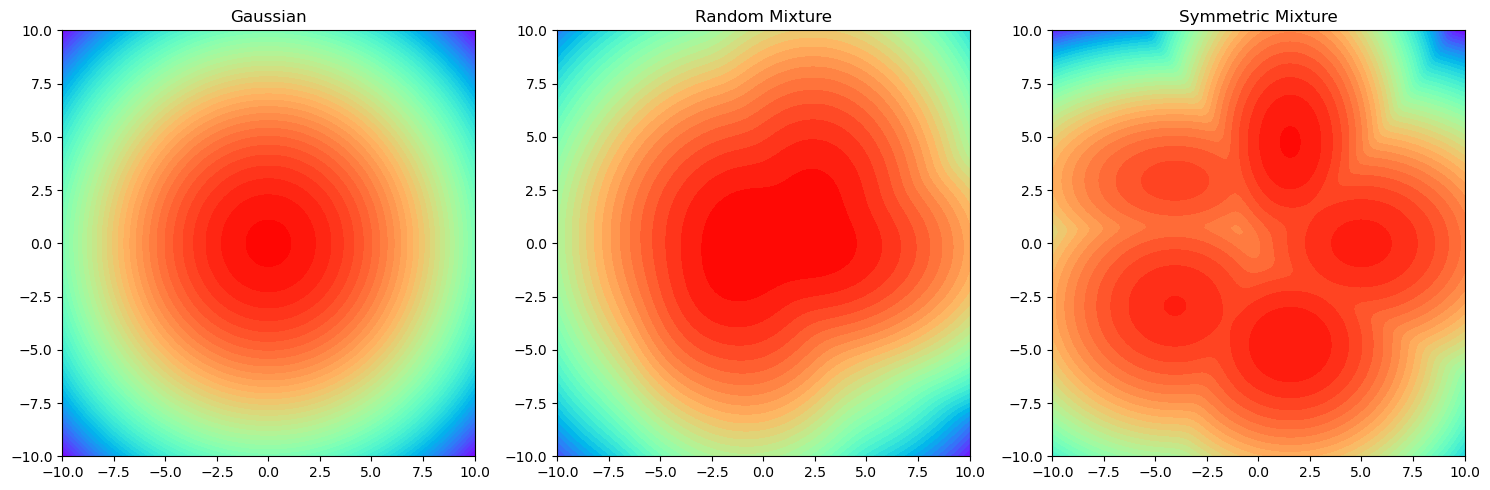

In [6]:
# same but contour plot
fig, axies = plt.subplots(1, len(densities), figsize=(15, 5))
scale = 10
bins = 100

for ax, (name, density) in zip(axies, densities.items()):
    x = torch.linspace(-scale, scale, bins)
    y = torch.linspace(-scale, scale, bins)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
    with torch.no_grad():
        log_probs = density.log_prob(grid).cpu().numpy().reshape(bins, bins)
    ax.contourf(X.cpu(), Y.cpu(), log_probs, levels=50, cmap="rainbow")
    ax.set_title(name)
plt.tight_layout()
plt.show()

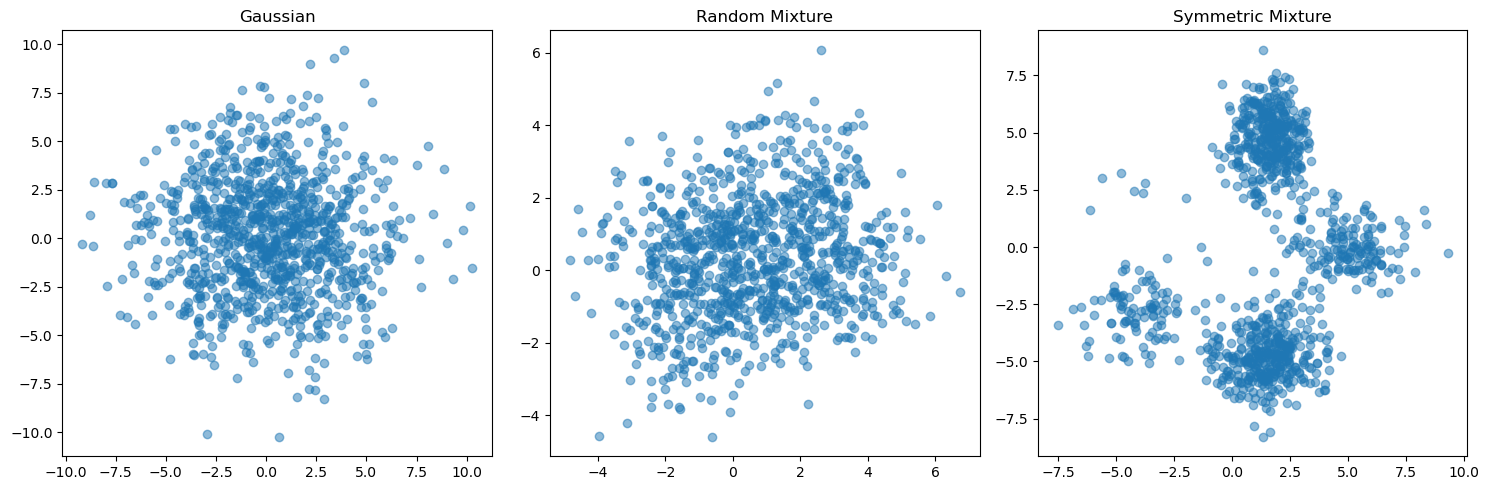

In [7]:
# same but scatter plot of samples
fig, axies = plt.subplots(1, len(densities), figsize=(15, 5))
num_samples = 1000
for ax, (name, density) in zip(axies, densities.items()):
    samples = density.sample(num_samples).cpu().numpy()
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    ax.set_title(name)
plt.tight_layout()
plt.show()

## Section 2: Numerical methods to simulate SDEs
Given $T>0$. We are given a stochastic differential equation (SDE) of the form
$$
d X_t = a(X_t, t) dt + \sigma(X_t, t) d W_t
$$
where 
$$
a: \mathbb{R}^n \times [0, T] \to \mathbb{R}^n, \\
\sigma: \mathbb{R}^n \times [0, T] \to \mathbb{R}^n,
$$
$W_t$ is standard Brownian motion. For simplicity, in most scenarios we consider, $\sigma(X_t, t)$ won't depend on $X_t$, so we may write $\sigma_t = \sigma(X_t, t)$.


In [8]:
# class to encapsulate SDE definition
class SDE(ABC):
    @abstractmethod
    def drift(self, x, t):
        """
        Compute the drift term a(x, t) of the SDE at state x and time t
        """
        pass

    @abstractmethod
    def diffusion(self, x, t):
        """
        Compute the diffusion term sigma(x, t) of the SDE at state x and time t
        """
        pass


#### Define Brownian motion
Recall the standard Brownian motion is
$$
dX_t = d W_t, X_0 = 0. 
$$
A scaled version is
$$
d X_t = \sigma d W_t
$$

In [9]:
class BrownianMotion(SDE):
    def __init__(self, sigma: float = 1.0):
        self.sigma = sigma
    
    def drift(self, x, t):
        # drift is zero for Brownian motion
        return torch.zeros_like(x)

    def diffusion(self, x, t):
        return self.sigma * torch.ones_like(x)

## Section 3: Numerical Methods for Simulating SDEs
To be able to simulate the SDE, we need to discretize time. There are several numerical methods to do so. 

Here, we focus on the Euler-Maruyama discretization method. Let $h = \Delta t$ be the step-size, then
$$
d X_t = a(X_t, t) dt + \sigma(X_t, t) dW_t \\
\to X_{t+h} = X_t + h a(X_t, t) + \sqrt{h} \sigma(X_t, t) Z_t,
$$
where $Z_t \sim \mathcal{N}(0, I_n)$


In [10]:
class Simulator(ABC):
    @abstractmethod
    def step(self, x, t, dt):
        """
        Simulate one step of the SDE from state x at time t with step size dt
        """
        pass
    
    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor) -> torch.Tensor:
        """
        Simulate the SDE starting from initial state x over the time points in ts
        """
        for i in range(len(ts)-1):
            dt = ts[i+1] - ts[i]
            x = self.step(x, ts[i], dt)
        return x
    
    @torch.no_grad()
    def simulate_trajectory(self, x: torch.Tensor, ts: torch.Tensor) -> torch.Tensor:
        """
        Simulate the SDE starting from initial state x over the time points in ts and return the full trajectory
        """
        trajectory = [x.clone()]
        for i in range(len(ts)-1):
            dt = ts[i+1] - ts[i]
            x = self.step(x, ts[i], dt)
            trajectory.append(x.clone())
        return torch.stack(trajectory, dim=1)

In [11]:
class EulerMaruyama(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, x: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        drift = self.sde.drift(x, t)
        diffusion = self.sde.diffusion(x, t)
        noise = torch.randn_like(x)
        return x + drift * dt + diffusion * noise * torch.sqrt(dt)

#### Simulate Brownian motion
Recall the standard Brownian motion is
$$
dX_t = d W_t, X_0 = 0. 
$$
A scaled version is
$$
d X_t = \sigma d W_t
$$
Euler-Maruyama discretizatization gives
$$
X_{t+h} = \sqrt{h} \sigma Z_t
$$
where $Z_t \sim \mathcal{N}(0, I_n)$

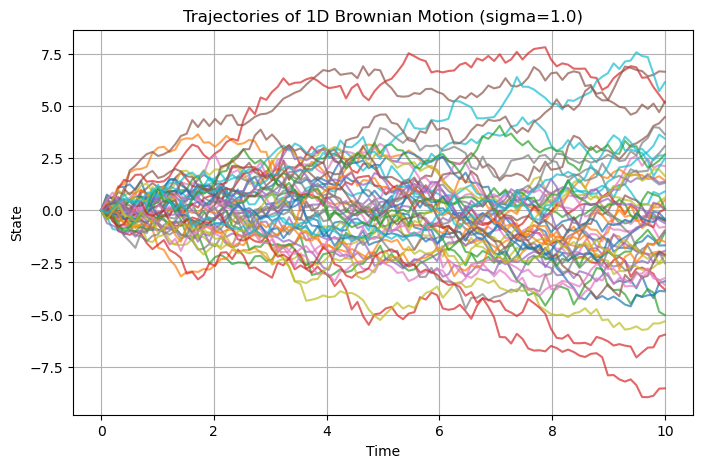

In [12]:
# plot trajectories of Brownian motion
sigma = 1.0
num_trajs = 50

brown_motion = BrownianMotion(sigma=sigma)
simulator = EulerMaruyama(brown_motion)
# initial state is zero for all samples
x0 = torch.zeros(num_trajs, 1).to(device)
ts = torch.linspace(0, 10, 100).to(device)

trajectories = simulator.simulate_trajectory(x0, ts).cpu().numpy()

plt.figure(figsize=(8, 5))
for i in range(num_trajs):
    plt.plot(ts.cpu(), trajectories[i, :, 0], alpha=0.7)
plt.title(f"Trajectories of 1D Brownian Motion (sigma={sigma})")
plt.xlabel("Time")
plt.ylabel("State")
plt.grid()
plt.show()

In [13]:
# compute variance at time t
print("Variance at final time:", np.var(trajectories[:, -1, 0]))
print("Theoretical variance at time t:", sigma**2 * ts[-1].item())

Variance at final time: 9.829386
Theoretical variance at time t: 10.0


#### Simulate Ornstein-Uhlenbeck process
Recall the standard Ornstein-Uhlenbeck is
$$
dX_t = - X_t dt + \sqrt{2} d W_t, X_0 = x_0. 
$$
A scaled version is
$$
d X_t = - \theta X_t dt + \sigma dW_t
$$
We use Euler-Maruyama discretizatization to discretize

In [14]:
# define OU process
class OrnsteinUhlenbeck(SDE):
    def __init__(self, theta: float = 1.0, sigma: float = 1.0):
        self.theta = theta
        self.sigma = sigma
    
    def drift(self, x, t):
        return - self.theta * x

    def diffusion(self, x, t):
        return self.sigma * torch.ones_like(x)

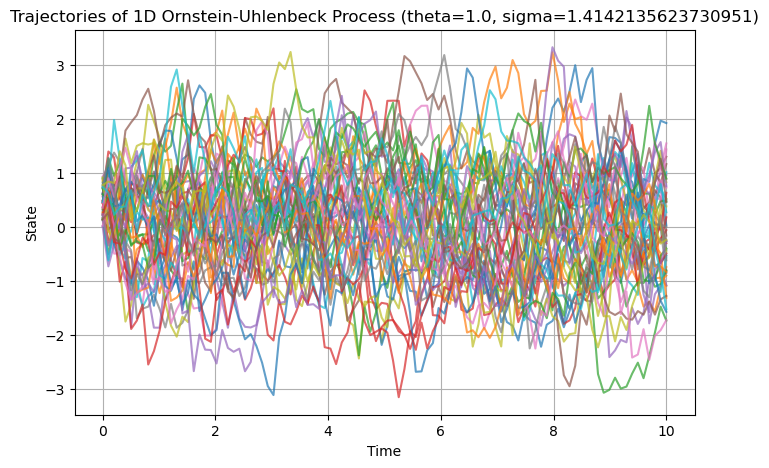

In [15]:
# plot OU process trajectory
theta = 1.0
sigma = np.sqrt(2 * theta)
num_trajs = 50

ou_process = OrnsteinUhlenbeck(theta=theta, sigma=sigma)
simulator = EulerMaruyama(ou_process)
# initialize at uniform on [0, 1]
x0 = torch.rand(num_trajs, 1).to(device)
ts = torch.linspace(0, 10, 100).to(device)

trajectories = simulator.simulate_trajectory(x0, ts).cpu().numpy()

plt.figure(figsize=(8, 5))
for i in range(num_trajs):
    plt.plot(ts.cpu(), trajectories[i, :, 0], alpha=0.7)
plt.title(f"Trajectories of 1D Ornstein-Uhlenbeck Process (theta={theta}, sigma={sigma})")
plt.xlabel("Time")
plt.ylabel("State")
plt.grid()
plt.show()

In [16]:
# compute variance at time t
print("Variance at final time:", np.var(trajectories[:, -1, 0]))

# one important difference between Brownian motion and OU process is that the variance of the OU process converges to a finite value as time goes to infinity, while the variance of Brownian motion grows without bound. 

Variance at final time: 0.8133485


## Section 4: Simulate Langevin dynamics
For a target density $p$, the Langevin SDE is given by 
$$
dX_t = \frac12 \sigma^2 \nabla \log p(X_t) dt + \sigma dW_t, X_0 = x_0
$$

Show that the OU process is a special kind of Langevin process, with the choice
$$
p(x) = \mathcal{N}(0, \frac{\sigma^2}{2\theta})
$$

In [17]:
# define Langevin SDE
class Langevin(SDE):
    def __init__(self, tar_density: Density, sigma: float = 1.0):
        self.tar_density = tar_density
        self.sigma = sigma
    
    def drift(self, x, t):
        # drift is the score function of the target density
        return self.tar_density.score(x) * self.sigma**2 / 2

    def diffusion(self, x, t):
        return self.sigma * torch.ones_like(x)

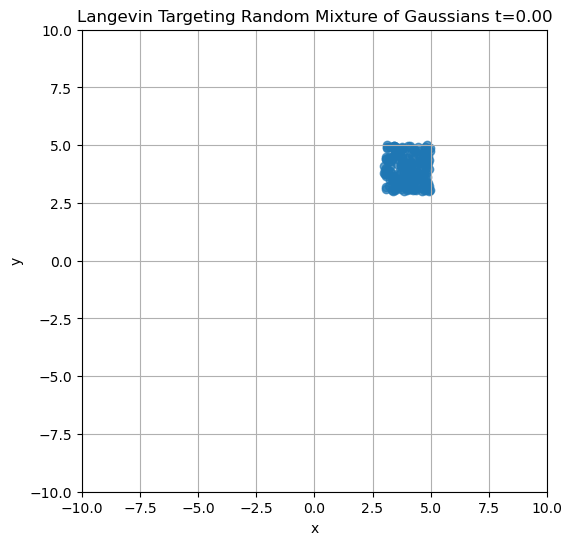

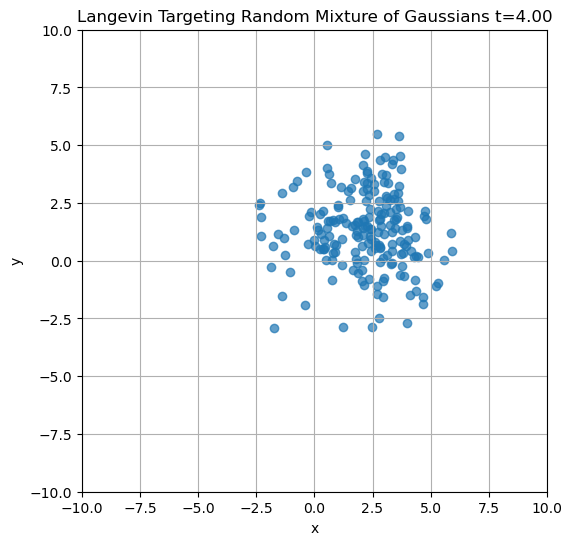

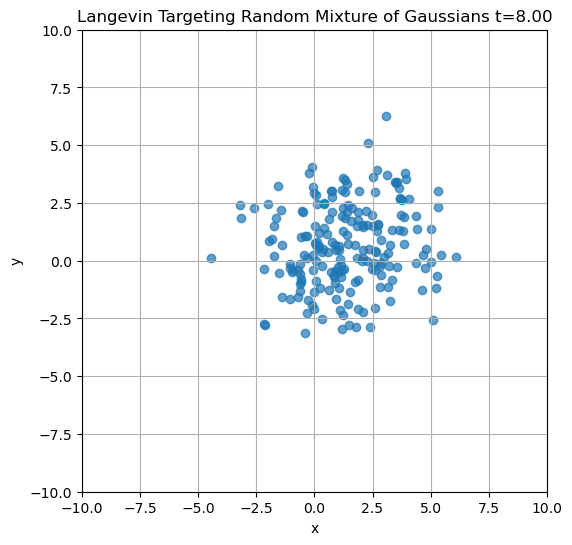

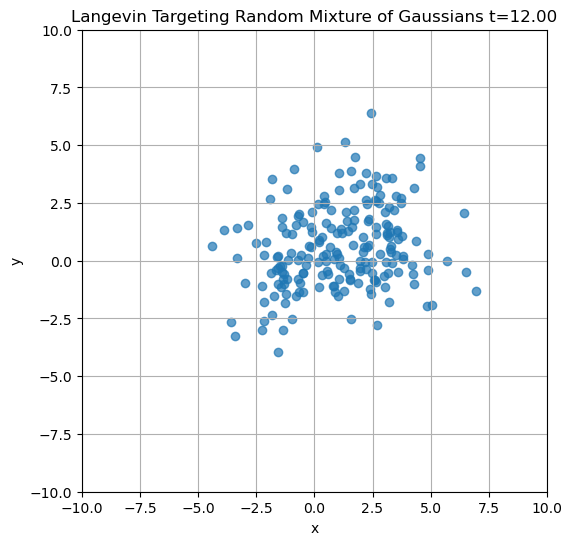

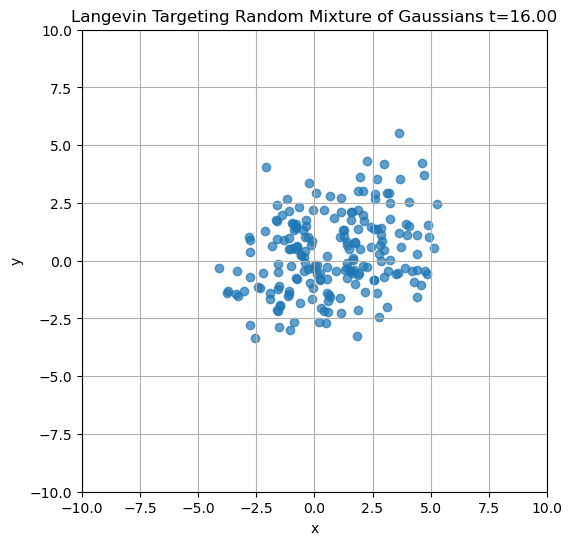

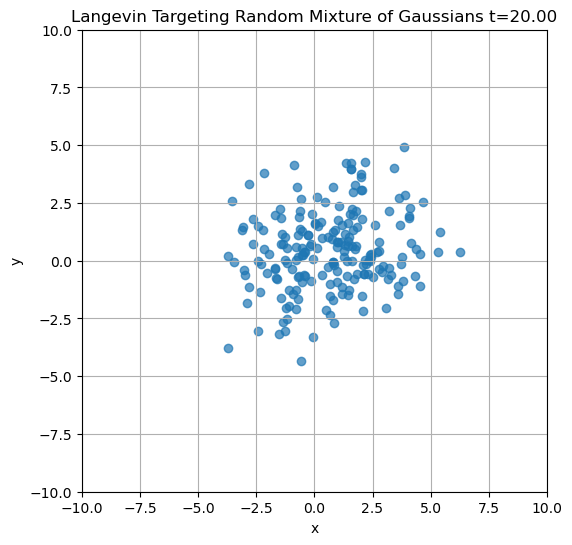

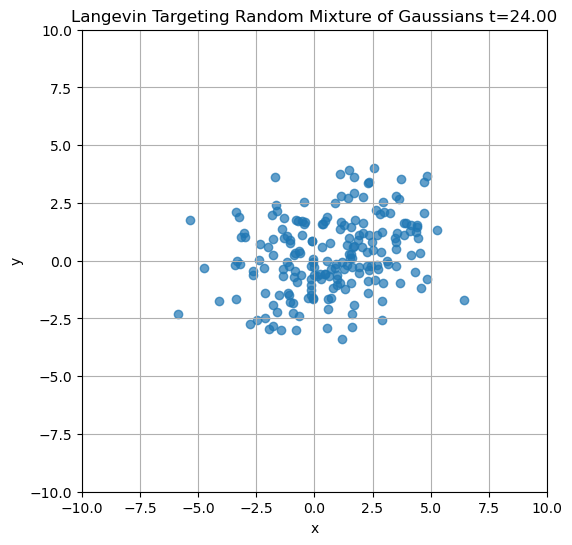

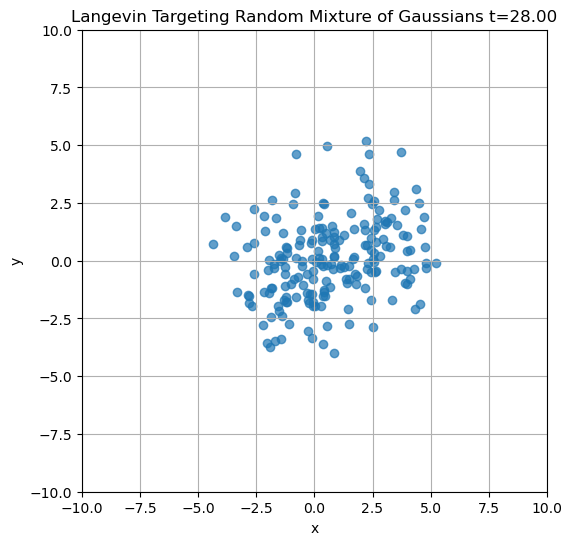

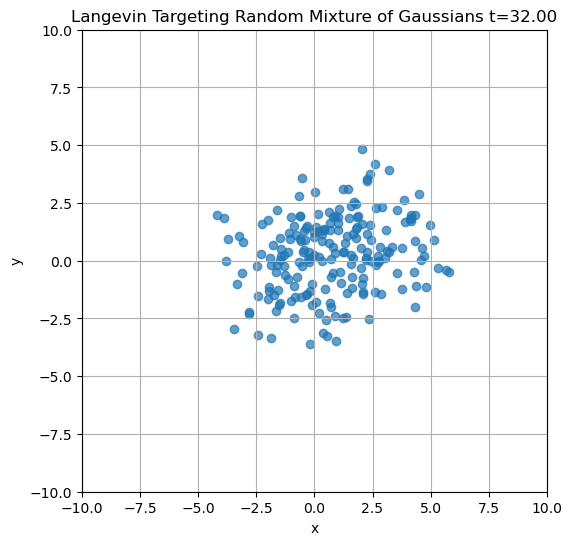

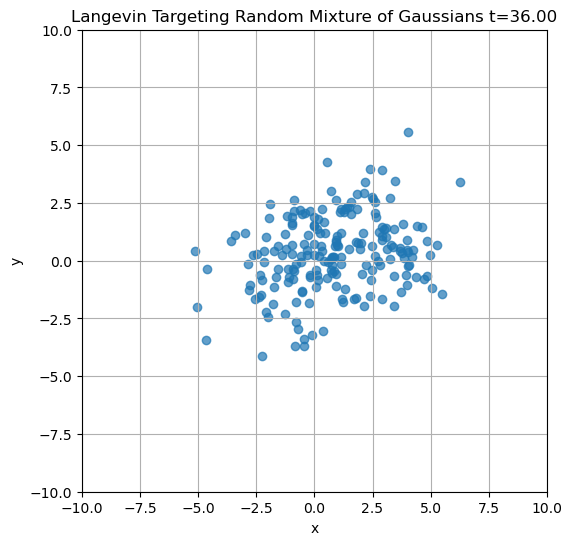

In [38]:
# Simulate Langevin dynamics targeting the symmetric mixture of Gaussians
num_trajs = 200
num_iters = 100
total_time = 40.0
tar_density = densities["Random Mixture"]
langevin = Langevin(tar_density=tar_density, sigma=np.sqrt(2.0))
simulator = EulerMaruyama(langevin)
# initialize at uniform on [3, 4]^2
x0 = torch.rand(num_trajs, 2).to(device) * 2 + 3
ts = torch.linspace(0, total_time, num_iters).to(device)
trajectories = simulator.simulate_trajectory(x0, ts).cpu().numpy()
# trajectories shape is (num_trajs, num_iters, 2)
# plot trajectories

def plot_per_iter(trajectories, total_time, num_iters):
    for i in range(num_iters):
        if i % 10 == 0:  # plot every 10th iter
            plt.figure(figsize=(6, 6))
            plt.scatter(trajectories[:, i, 0], trajectories[:, i, 1], alpha=0.7)
            plt.title("Langevin Targeting Random Mixture of Gaussians t=%.2f" % (total_time/num_iters*i))
            plt.xlabel("x")
            plt.ylabel("y")
            plt.xlim(-10, 10)
            plt.ylim(-10, 10)
            plt.grid()
            plt.show()
        
plot_per_iter(trajectories, total_time, num_iters)

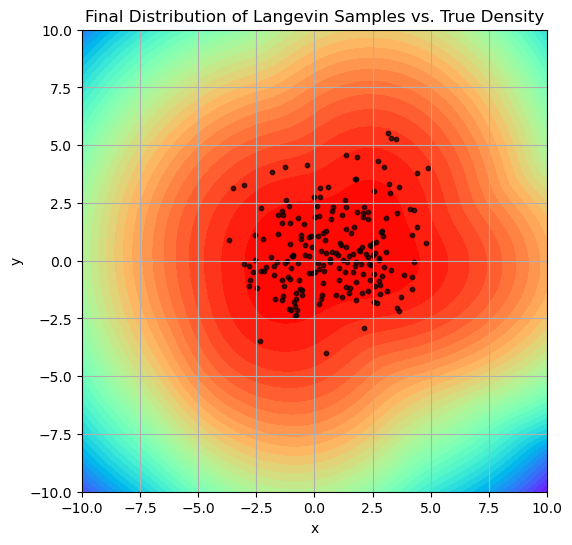

In [39]:
# plot final distribution of samples vs. true density
def plot_final_dist(trajectories, tar_density):
    x = torch.linspace(-10, 10, 100)
    y = torch.linspace(-10, 10, 100)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
    with torch.no_grad():
        log_probs = tar_density.log_prob(grid).cpu().numpy().reshape(100, 100)
    plt.figure(figsize=(6, 6))
    plt.contourf(X.cpu(), Y.cpu(), log_probs, levels=50, cmap="rainbow")
    plt.scatter(trajectories[:, -1, 0], trajectories[:, -1, 1], alpha=0.7, color="black", s=10)
    plt.title("Final Distribution of Langevin Samples vs. True Density")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid()
    plt.show()
    
plot_final_dist(trajectories, tar_density)

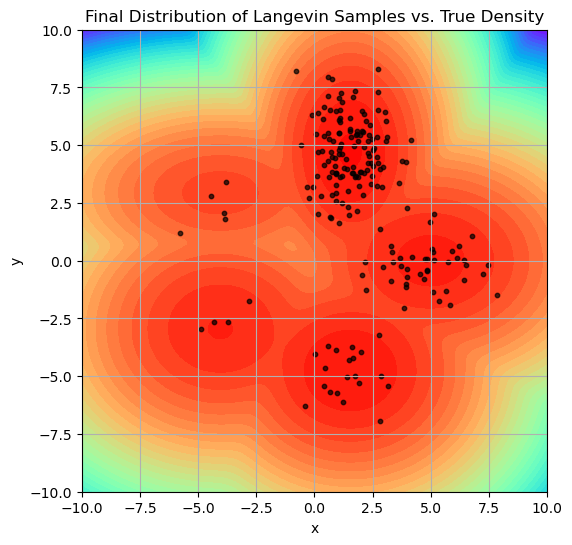

In [40]:
# do the same for the symmetric mixture of Gaussians
tar_density = densities["Symmetric Mixture"]
langevin = Langevin(tar_density=tar_density, sigma=np.sqrt(2.0))
simulator = EulerMaruyama(langevin)
# initialize at uniform on [3, 4]^2
x0 = torch.rand(num_trajs, 2).to(device) * 2 + 3
ts = torch.linspace(0, total_time, num_iters).to(device)
trajectories = simulator.simulate_trajectory(x0, ts).cpu().numpy()

plot_final_dist(trajectories, tar_density)


# 

## Section 5: Langevin dynamics for multi-mode distribution
We simulate Langevin for two mixture of Gaussians where the modes become further and further away

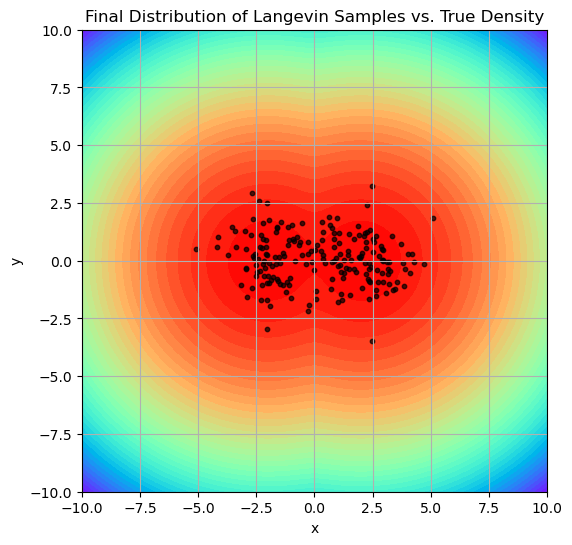

In [51]:
# define a mixture of two Gaussians
distance_two_modes = 4.0


def langevin_two_modes(distance_two_modes):
    means = torch.tensor([[distance_two_modes/2, 0.0], [-distance_two_modes/2, 0.0]])
    mixture1 = MixtureOfGaussians(means=means, covs=torch.eye(2).unsqueeze(0).repeat(2, 1, 1), weights=torch.tensor([0.5, 0.5])).to(device)
    langevin = Langevin(tar_density=mixture1, sigma=np.sqrt(2.0))
    simulator = EulerMaruyama(langevin)
    # initialize at uniform on around one mode [distance_two_modes/2-1, distance_two_modes/2+1] x [-1, 1]
    x0 = torch.rand(num_trajs, 2).to(device)
    x0[:, 0] = x0[:, 0] * 2 - 1 + distance_two_modes/2
    x0[:, 1] = x0[:, 1] * 2 - 1
    ts = torch.linspace(0, total_time, num_iters).to(device)
    trajectories = simulator.simulate_trajectory(x0, ts).cpu().numpy()

    plot_final_dist(trajectories, mixture1)
    
langevin_two_modes(distance_two_modes)

Now try with distance_two_modes=8.0 or 10.0
What happens?! Why?!

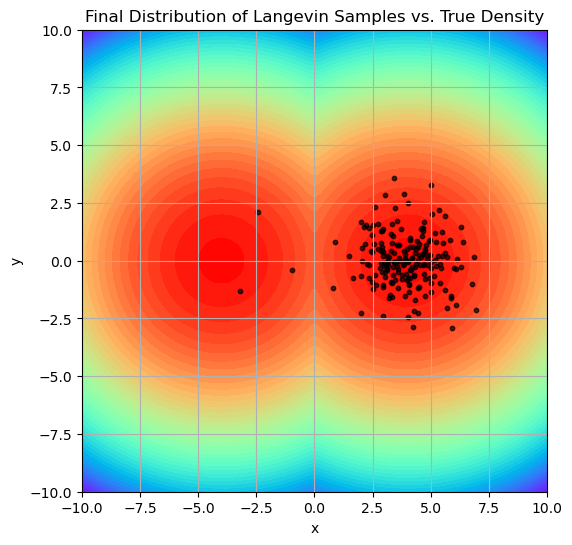

In [54]:
distance_two_modes = 8.0
langevin_two_modes(distance_two_modes)

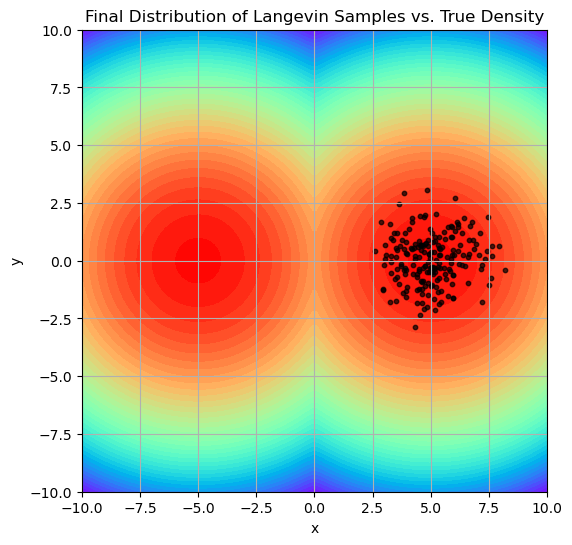

In [55]:
distance_two_modes = 10.0
langevin_two_modes(distance_two_modes)